# Testing the environment

In [1]:
import os, sys
import gymnasium as gym
import time
from copy import deepcopy

import text_flappy_bird_gym


env = gym.make("TextFlappyBird-v0")
obs, info = env.reset()

print("number of actions", env.action_space.n)
print("action space", env.action_space)
print("observation space", env.observation_space)

print("obs", obs)
print("info", info)
steps = 0
while True:

    # Select next action
    action = (
        env.action_space.sample()
    )  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    steps += 1

    print("--------------------", steps, "--------------------")
    print("action", action)
    print("obs", obs)
    print("reward", reward)
    print("done", done)
    print("info", info)

    if done or steps > 100:
        break

    break

number of actions 2
action space Discrete(2)
observation space Tuple(Discrete(14), Discrete(22, start=-11))
obs (13, 0)
info {'score': 0, 'player': [6, 7], 'distance': 13.0}
-------------------- 1 --------------------
action 0
obs (12, 0)
reward 1
done False
info {'score': 0, 'player': [6, 7], 'distance': 12.0}


Random policy average reward: 9.367


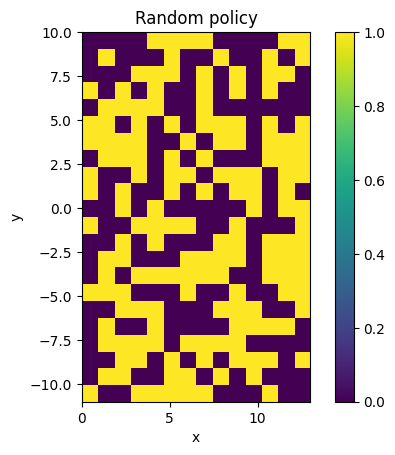

zero policy average reward: 4.0


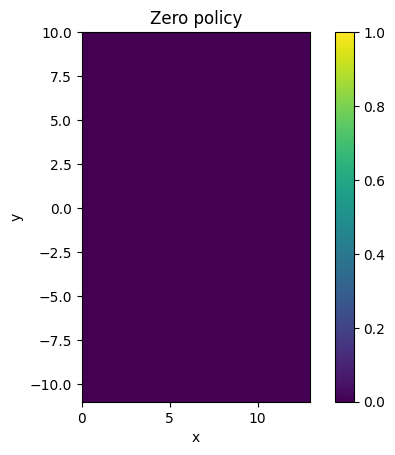

one policy average reward: 13.0


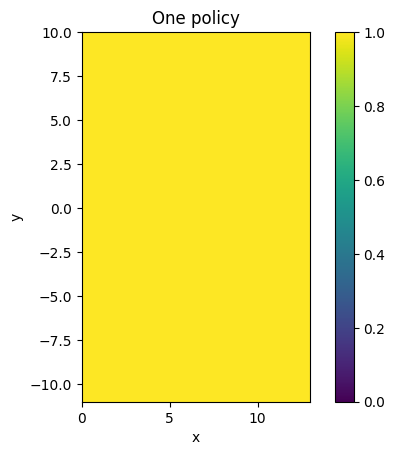

Simple policy average reward: 252.019


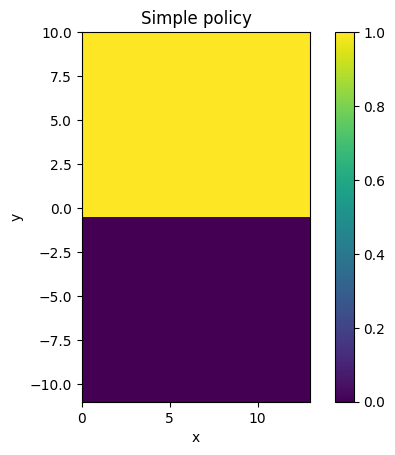

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


def evaluate_policy(env, policy, num_episodes=100):
    rewards = []
    for _ in range(num_episodes):

        obs, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done:
            action = policy[obs]
            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 10000:  # break if the episode is too long
                break
        rewards.append(episode_reward)

    return sum(rewards) / num_episodes


def plot_policy(policy, title="Policy"):
    """
    Plot the policy
    States are a tuple (x, y) Tuple(Discrete(14), Discrete(22, start=-11))
    Action space Discrete(2)
    """

    x = np.arange(14)
    y = np.arange(-11, 11)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j])
            Z[i, j] = policy[state]

    plt.imshow(
        Z, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", vmin=0, vmax=1
    )
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    # plt.show()


random_policy = defaultdict(lambda: env.action_space.sample())
avg_reward = evaluate_policy(env, random_policy, 1000)
print("Random policy average reward:", avg_reward)
plot_policy(random_policy, title="Random policy")
plt.show()

zero_policy = defaultdict(lambda: 0)
avg_reward = evaluate_policy(env, zero_policy, 100)
print("zero policy average reward:", avg_reward)
plot_policy(zero_policy, title="Zero policy")
plt.show()


one_policy = defaultdict(lambda: 1)
avg_reward = evaluate_policy(env, one_policy, 100)
print("one policy average reward:", avg_reward)
plot_policy(one_policy, title="One policy")
plt.show()


simple_policy = {}

for x in range(14):
    for y in range(-30, 30):
        state = (x, y)
        simple_policy[state] = 0 if y < 0 else 1

avg_reward = evaluate_policy(env, simple_policy, 1000)
print("Simple policy average reward:", avg_reward)
plot_policy(simple_policy, title="Simple policy")
plt.show()


# MC Control

In [4]:
import numpy as np


def generate_episode_from_Q(env, Q, epsilon, nA):

    """generates an episode from following the epsilon-greedy policy"""
    episode = []
    state, _ = env.reset()
    while True:
        action = (

            np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
            if state in Q
            else env.action_space.sample()
        )


        # take a step in the environement

        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode



def get_probs(Q_s, epsilon, nA):

    """obtains the action probabilities corresponding to epsilon-greedy policy"""
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s



def update_Q(env, episode, Q, alpha, gamma):

    """updates the action-value function estimate using the most recent episode"""
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards) + 1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (
            sum(rewards[i:] * discounts[: -(1 + i)]) - old_Q
        )


    return Q



def mc_control(

    env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05
):
    avg_rewards = []
    episodes = []
    best_policy = defaultdict(lambda: 0)
    best_Q = defaultdict(lambda: np.zeros(nA))
    best_avg_reward = 0


    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start


    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress and evaluate the policy

        if i_episode % 1000 == 0:

            policy = defaultdict(lambda: 0)

            for state, actions in Q.items():
                policy[state] = np.argmax(actions)

            avg_reward = evaluate_policy(env, policy, num_episodes=100)
            avg_rewards.append(avg_reward)
            episodes.append(i_episode)

            if avg_reward >= best_avg_reward:
                best_avg_reward = avg_reward
                best_policy = policy
                best_Q = deepcopy(Q)


            print("\rEpisode {}/{}. ".format(i_episode, num_episodes), end="")
            print("Best Average reward: {}".format(best_avg_reward), end="")

        # set the value of epsilon
        epsilon = max(epsilon * eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())


    return policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q

In [4]:
policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = mc_control(
    env, 50000, 0.02
)

Episode 50000/50000. Best Average reward: 10001.0

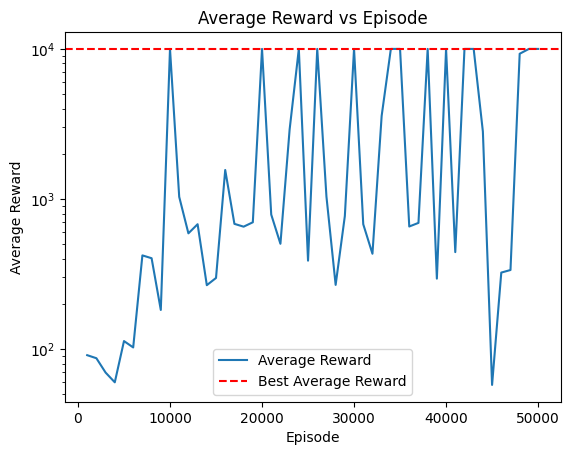

In [12]:
plt.plot(episodes, avg_rewards, label="Average Reward")
plt.axhline(best_avg_reward, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

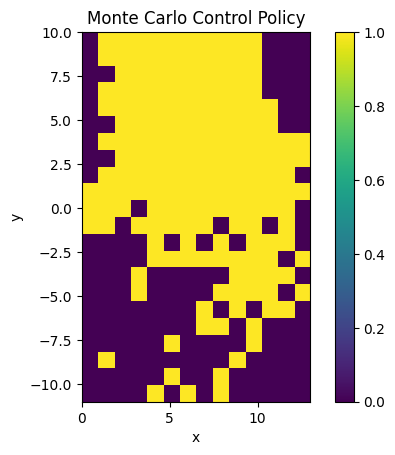

In [5]:
plot_policy(best_policy, title="Monte Carlo Control Policy")
plt.show()


This figure shows that the MC control algorithm approximatively learns to flap if the bird is too low and not to flap if the bird is too high for small x which is rather expected.

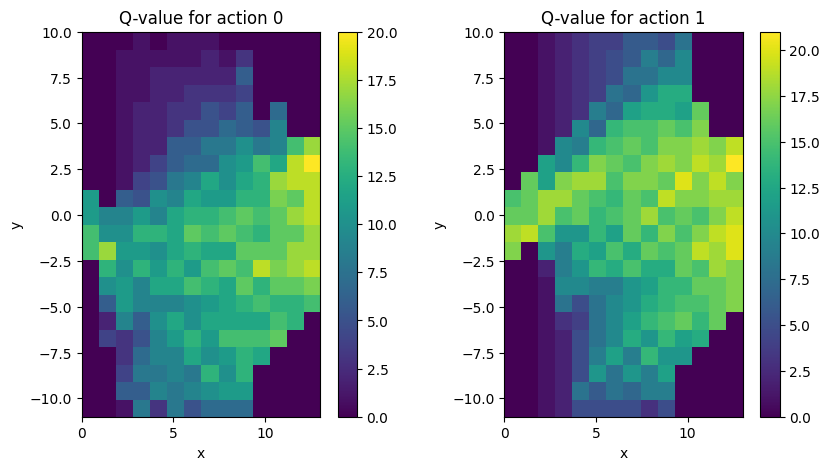

In [14]:
def plot_Q_value(Q, title="Q-value"):
    x = np.arange(14)
    y = np.arange(-11, 11)
    X, Y = np.meshgrid(x, y)
    Z0 = np.zeros_like(X)
    Z1 = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j])
            Z0[i, j] = Q[state][0]
            Z1[i, j] = Q[state][1]

    plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Z0, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title + " for action 0")

    plt.subplot(1, 2, 2)
    plt.imshow(Z1, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title + " for action 1")

    plt.show()


plot_Q_value(best_Q, title="Q-value")

# Sarsa lambda

In [5]:
def choose_action(env, state, Q, epsilon):
    if not state in Q or np.random.random() < epsilon:
        return env.action_space.sample()

    return np.argmax(Q[state])


def sarsa_lambda_agent(
    env,
    num_episodes,
    alpha,
    lambda_=1,
    gamma=1.0,
    eps_start=1.0,
    eps_decay=0.99999,
    eps_min=0.05,
):
    avg_rewards = []
    episodes = []
    best_policy = defaultdict(lambda: 0)
    best_avg_reward = 0
    best_Q = defaultdict(lambda: np.zeros(nA))

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    visited = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    for i_episode in range(1, num_episodes + 1):
        # monitor progress and evaluate the policy
        if i_episode % 1000 == 0:

            policy = defaultdict(lambda: 0)
            for state, actions in Q.items():
                policy[state] = np.argmax(actions)
            avg_reward = evaluate_policy(env, policy, num_episodes=100)
            avg_rewards.append(avg_reward)
            episodes.append(i_episode)

            if avg_reward >= best_avg_reward:
                best_avg_reward = avg_reward
                best_policy = policy
                best_Q = deepcopy(Q)

            print("\rEpisode {}/{}. ".format(i_episode, num_episodes), end="")
            print("Average reward: {}".format(avg_reward), end="")

            # sys.stdout.flush()

        # set the value of epsilon
        epsilon = max(epsilon * eps_decay, eps_min)

        state, _ = env.reset()
        action = choose_action(env, state, Q, epsilon)
        while True:
            next_state, reward, done, _, _ = env.step(action)
            next_action = choose_action(env, next_state, Q, epsilon)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]

            next_action = choose_action(env, next_state, Q, epsilon)
            Q[state][action] = Q[state][action] + alpha * (
                reward + gamma * Q[next_state][next_action] - Q[state][action]
            )
            visited[state][action] += 1

            for state in Q:
                for action in range(nA):
                    Q[state][action] += alpha * delta * visited[state][action]
                    visited[state][action] *= gamma * lambda_

            state = next_state
            action = next_action

            if done:
                break

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q

Episode 50000/50000. Average reward: 530.292

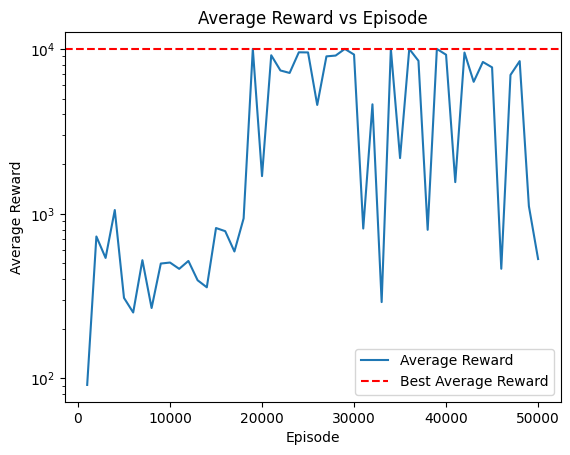

In [33]:
policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = (
    sarsa_lambda_agent(env, 50000, 0.02, lambda_=0.9)
)



plt.plot(episodes, avg_rewards, label="Average Reward")
plt.axhline(best_avg_reward, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

Episode 50000/50000. Average reward: 9679.02

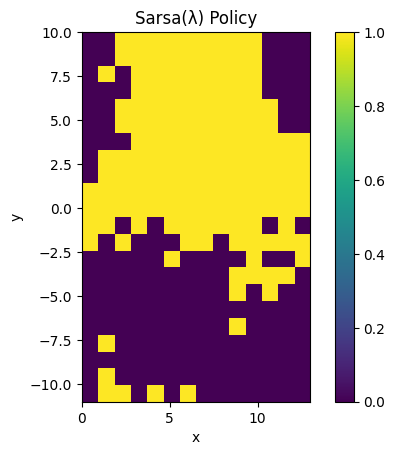

In [26]:
plot_policy(best_policy, title="Sarsa(λ) Policy")

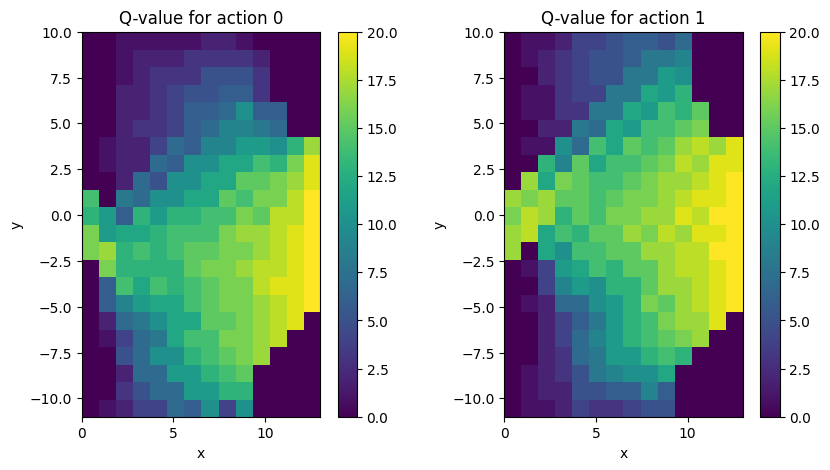

In [32]:
plot_Q_value(best_Q, title="Q-value")

# Parameters sweep for Sarsa lambda

Episode 50000/50000. Average reward: 8130.76

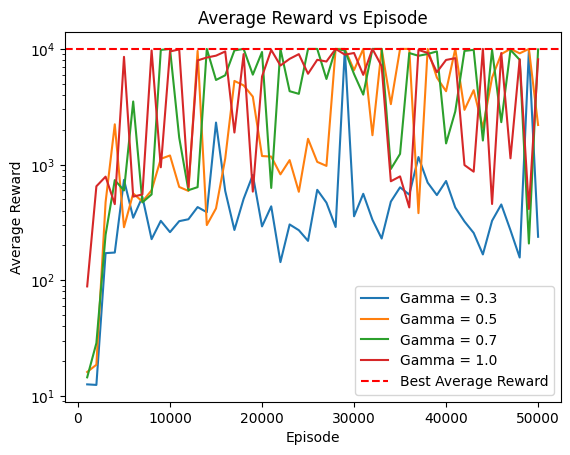

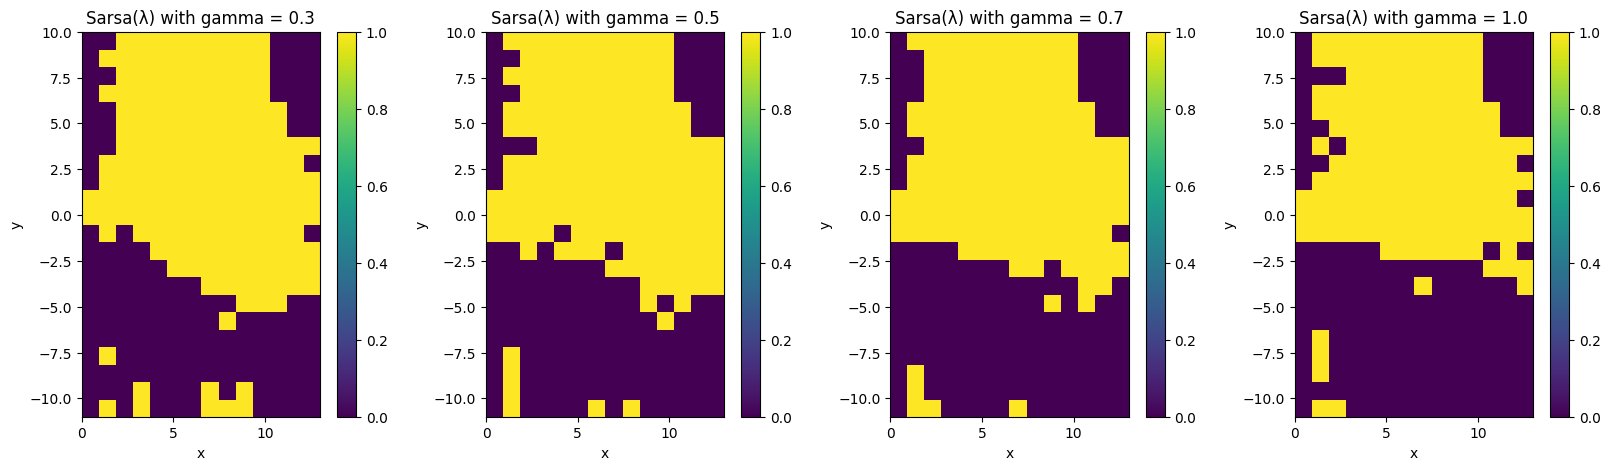

In [10]:
gamma_list = [0.3, 0.5, 0.7, 1.0]

best_policies = []
for gamma in gamma_list:
    policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = (
        sarsa_lambda_agent(env, 50000, 0.02, lambda_=0.9, gamma=gamma)
    )
    best_policies.append(best_policy)
    plt.plot(episodes, avg_rewards, label="Gamma = {}".format(gamma))



plt.axhline(10001, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

plt.subplots(1, 4, figsize=(20, 5))
for i, policy in enumerate(best_policies):
    plt.subplot(1, 4, i + 1)
    plot_policy(policy, title="Sarsa(λ) with gamma = {}".format(gamma_list[i]))

plt.show()

Episode 50000/50000. Average reward: 6160.74

C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:68: RuntimeWarning: overflow encountered in scalar multiply
  Q[state][action] += alpha * delta * visited[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:68: RuntimeWarning: invalid value encountered in scalar add
  Q[state][action] += alpha * delta * visited[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:69: RuntimeWarning: overflow encountered in scalar multiply
  visited[state][action] *= gamma * lambda_


Episode 50000/50000. Average reward: 4.0

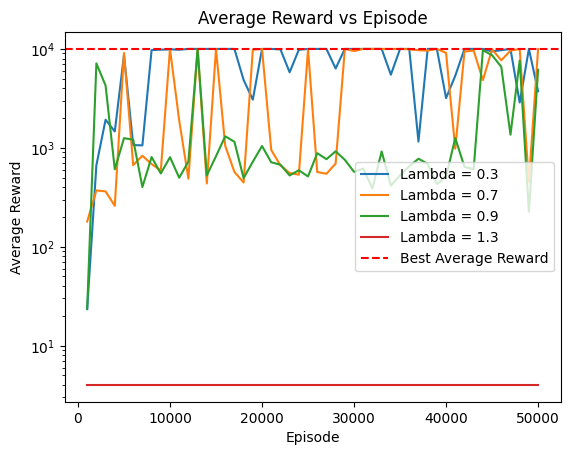

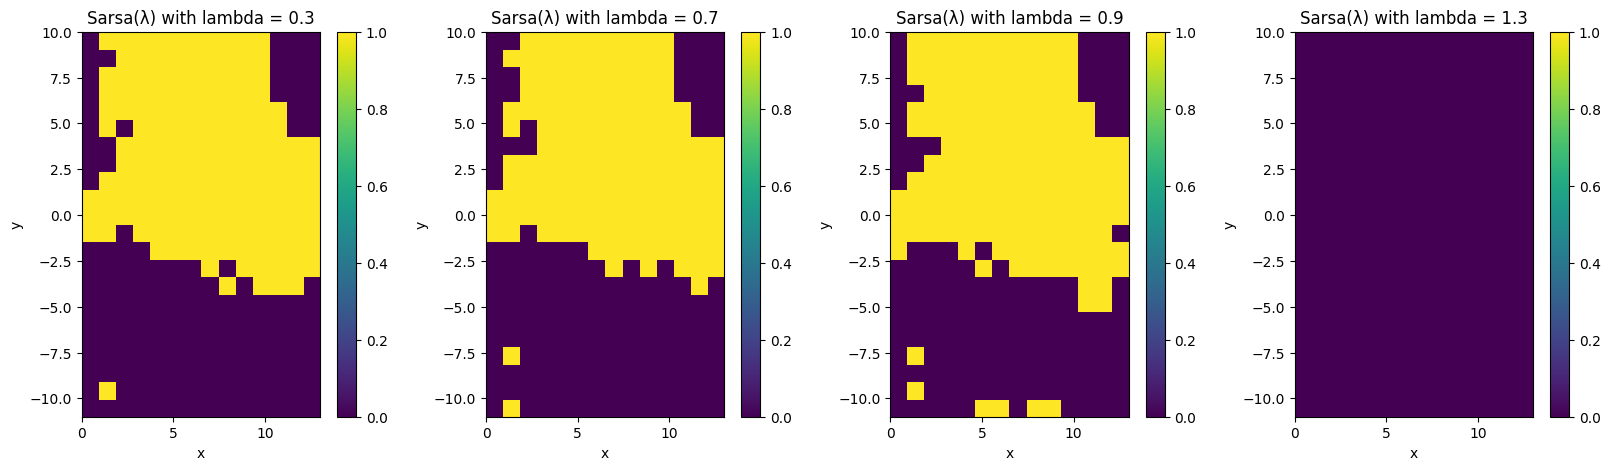

In [11]:
lambda_list = [0.3, 0.7, 0.9, 1.3]

best_policies = []

for lambda_ in lambda_list:
    policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = (
        sarsa_lambda_agent(env, 50000, 0.02, lambda_=lambda_, gamma=0.9)
    )
    best_policies.append(best_policy)
    plt.plot(episodes, avg_rewards, label="Lambda = {}".format(lambda_))

plt.axhline(10001, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

plt.subplots(1, len(lambda_list), figsize=(20, 5))
for i, policy in enumerate(best_policies):
    plt.subplot(1, len(lambda_list), i + 1)
    plot_policy(policy, title="Sarsa(λ) with lambda = {}".format(lambda_list[i]))

plt.show()

Episode 21000/50000. Average reward: 7.36520

C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:68: RuntimeWarning: overflow encountered in scalar add
  Q[state][action] += alpha * delta * visited[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:58: RuntimeWarning: overflow encountered in scalar subtract
  delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:62: RuntimeWarning: overflow encountered in scalar subtract
  reward + gamma * Q[next_state][next_action] - Q[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  Q[state][action] += alpha * delta * visited[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykernel_20752\1943457255.py:58: RuntimeWarning: invalid value encountered in scalar subtract
  delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
C:\Users\cleme\AppData\Local\Temp\ipykerne

Episode 50000/50000. Average reward: 4.0

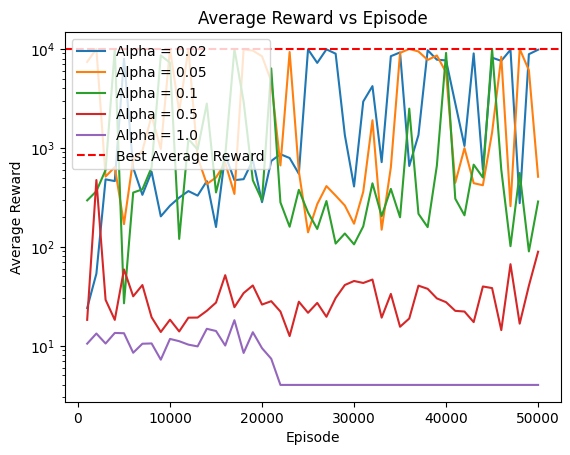

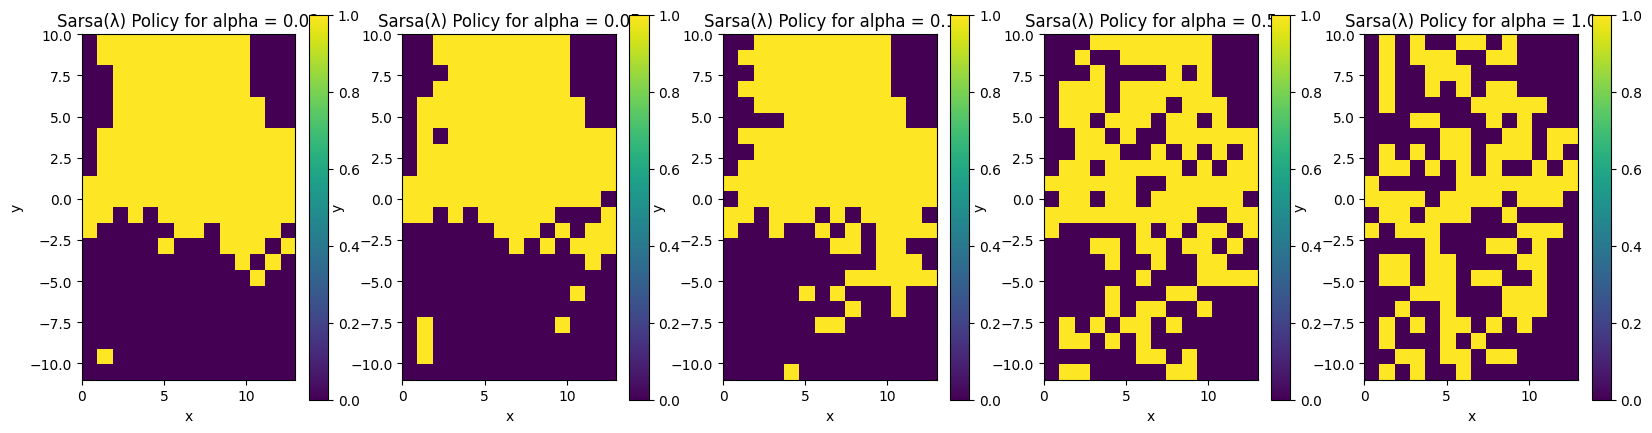

In [12]:
alpha_list = [0.02, 0.05, 0.1, 0.5, 1.0]

best_policies = []
for alpha in alpha_list:
    policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = (
        sarsa_lambda_agent(env, 50000, alpha, lambda_=0.9, gamma=0.9)
    )
    best_policies.append(best_policy)
    plt.plot(episodes, avg_rewards, label="Alpha = {}".format(alpha))

plt.axhline(10001, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

plt.subplots(1, 5, figsize=(20, 5))
for i, policy in enumerate(best_policies):
    plt.subplot(1, 5, i + 1)
    plot_policy(policy, title="Sarsa(λ) Policy for alpha = {}".format(alpha_list[i]))

plt.show()


# Adaptation to other configurations of the game

Episode 50000/50000. Average reward: 90.361

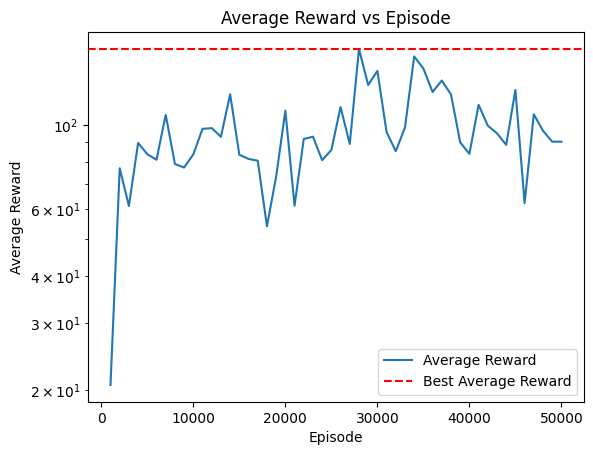

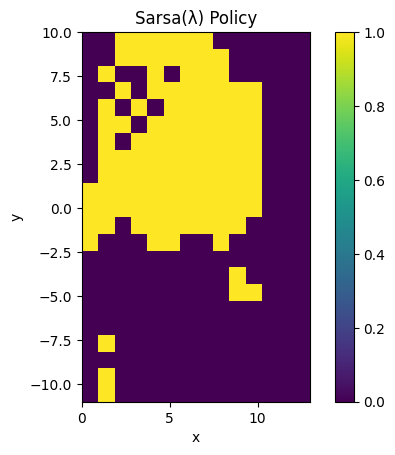

In [17]:
env = gym.make("TextFlappyBird-v0", height=20, width=15, pipe_gap=4)

policy, Q, avg_rewards, episodes, best_policy, best_avg_reward, best_Q = (
    sarsa_lambda_agent(env, 50000, 0.02, lambda_=0.9)
)



plt.plot(episodes, avg_rewards, label="Average Reward")
plt.axhline(best_avg_reward, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

plot_policy(best_policy, title="Sarsa(λ) Policy")
plt.show()

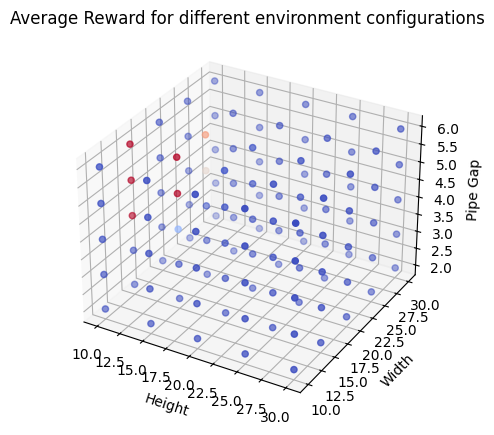

In [20]:
height_list = [10, 15, 20, 25, 30]
width_list = [10, 15, 20, 25, 30]
pipe_gap_list = [2, 3, 4, 5, 6]

X,Y,Z = [],[],[]
avg_rewards = []

for height in height_list:
    for width in width_list:
        for pipe_gap in pipe_gap_list:
            test_env = gym.make("TextFlappyBird-v0", height=height, width=width, pipe_gap=pipe_gap)
            X.append(height)
            Y.append(width)
            Z.append(pipe_gap)

            avg_rewards.append(evaluate_policy(test_env, best_policy, num_episodes=100))








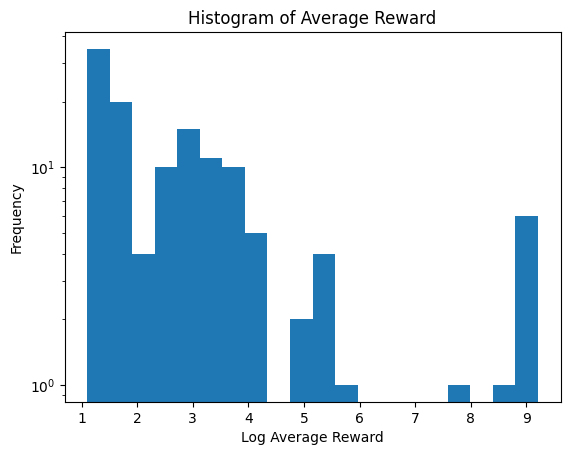

In [33]:
plt.hist(np.log(avg_rewards), bins=20)
plt.xlabel("Log Average Reward")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Histogram of Average Reward")
plt.show()


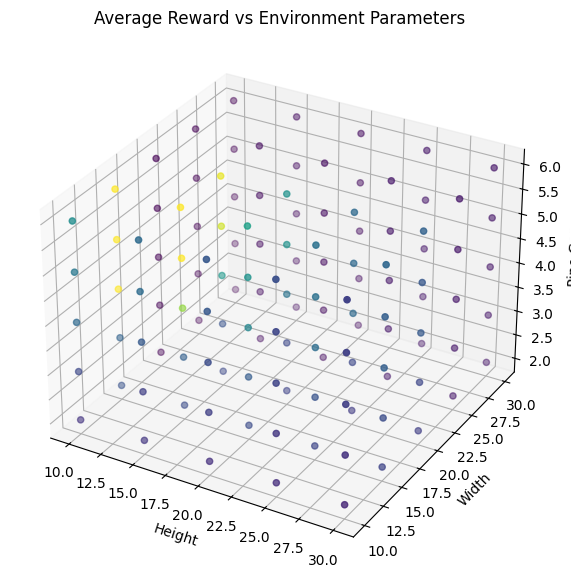

In [39]:
plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(X, Y, Z, c=np.log(avg_rewards), cmap="viridis")
ax.set_xlabel("Height")
ax.set_ylabel("Width")
ax.set_zlabel("Pipe Gap")
plt.title("Average Reward vs Environment Parameters")
plt.show()


In [36]:
group_1 = [i for i, r in enumerate(avg_rewards) if r < 1000]
group_2 = [i for i, r in enumerate(avg_rewards) if r >= 1000 and r < 8000]
group_3 = [i for i, r in enumerate(avg_rewards) if r >= 8000]

for i in group_1:
    print("Height: {}, Width: {}, Pipe Gap: {}, Average Reward: {}".format(X[i], Y[i], Z[i], avg_rewards[i]))

print("______________________________________________________________________________________")
for i in group_2:
    print("Height: {}, Width: {}, Pipe Gap: {}, Average Reward: {}".format(X[i], Y[i], Z[i], avg_rewards[i]))

print("______________________________________________________________________________________")
for i in group_3:
    print("Height: {}, Width: {}, Pipe Gap: {}, Average Reward: {}".format(X[i], Y[i], Z[i], avg_rewards[i]))
    


Height: 10, Width: 10, Pipe Gap: 2, Average Reward: 10.35
Height: 10, Width: 10, Pipe Gap: 3, Average Reward: 17.97
Height: 10, Width: 10, Pipe Gap: 4, Average Reward: 46.02
Height: 10, Width: 10, Pipe Gap: 5, Average Reward: 76.8
Height: 10, Width: 10, Pipe Gap: 6, Average Reward: 153.5
Height: 10, Width: 15, Pipe Gap: 2, Average Reward: 24.03
Height: 10, Width: 15, Pipe Gap: 3, Average Reward: 37.92
Height: 10, Width: 20, Pipe Gap: 2, Average Reward: 3.0
Height: 10, Width: 20, Pipe Gap: 3, Average Reward: 3.0
Height: 10, Width: 20, Pipe Gap: 4, Average Reward: 3.0
Height: 10, Width: 20, Pipe Gap: 5, Average Reward: 3.0
Height: 10, Width: 20, Pipe Gap: 6, Average Reward: 3.0
Height: 10, Width: 25, Pipe Gap: 2, Average Reward: 3.0
Height: 10, Width: 25, Pipe Gap: 3, Average Reward: 3.0
Height: 10, Width: 25, Pipe Gap: 4, Average Reward: 3.0
Height: 10, Width: 25, Pipe Gap: 5, Average Reward: 3.0
Height: 10, Width: 25, Pipe Gap: 6, Average Reward: 3.0
Height: 10, Width: 30, Pipe Gap: 2,